## Welcome to the pipeline of my zillow project

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.linear_model import LinearRegression

import aquire
import prep
import split_scale
import model
import features

from jupyterthemes import jtplot
jtplot.style()
import warnings
warnings.filterwarnings("ignore")

### Aquire

In [141]:
# define database to utilize and query to pull values
db = "zillow"
query = """
    SELECT 
        bathroomcnt as bathrooms,
        bedroomcnt as bedrooms, 
        calculatedfinishedsquarefeet as squarefeet,
        fips as counties,
        garagecarcnt as garage,
        taxvaluedollarcnt as taxvalue
        FROM properties_2017
        JOIN predictions_2017 USING (parcelid)
        WHERE transactiondate BETWEEN "2017-05-01" AND "2017-06-31"
            AND propertylandusetypeid in ("261")
            AND calculatedfinishedsquarefeet is not null
            AND NOT (finishedsquarefeet50 is not null AND finishedsquarefeet50 > calculatedfinishedsquarefeet)
            """

In [142]:
# pull data from mysql 
df = aquire.get_data(query, db)

### Prep

In [143]:
# why values were selected
data_dict = {
    "bathroomcnt":"selected bathroomcnt because calculatedbathnbr was always equal to bathroomcnt and they had some nulls", 
    "bedroomcnt":"this was the only bedroom value",
    "calculatedfinishedsquarefeet":"calculatedsqft had the least nulls. "
                                    "finishedsquarefeet6/12/13 all equaled calculated, so they were ignorable. "
                                    "for all finishedsquarefeet50 that were less than calculated, "
                                    "those values equaled the completedfirstfloor, therefore ignored. "
                                    "for all finishedsquarefeet50 that were greater than calculated, "
                                    "there were only six, and the anomaly was unknown, so they were removed",
    "taxvaluedollarcnt":"this was the only assessed property tax value data"
}

In [144]:
# remove rows where there are no bathroms or bedrooms
df = df [df.bedrooms != 0]
df = df [df.bathrooms != 0]
# remove rows with nulls
df = df.dropna()

In [145]:
df.head()

,bathrooms,bedrooms,squarefeet,counties,garage,taxvalue
2,3.0,4.0,2541.0,6059.0,2.0,880456.0
6,2.0,3.0,1668.0,6059.0,2.0,196483.0
7,2.5,3.0,1653.0,6059.0,2.0,605000.0
20,2.0,4.0,1485.0,6059.0,2.0,63338.0
31,1.0,2.0,1387.0,6059.0,1.0,280967.0


In [146]:
# make garage and counties categories 
df = df.astype({"counties": "category", "garage": "category"})

In [147]:
# separate df by counties
df_6037 = df [df.counties == 6037.0]
df_6059 = df [df.counties == 6059.0]
df_6111 = df [df.counties == 6111.0]

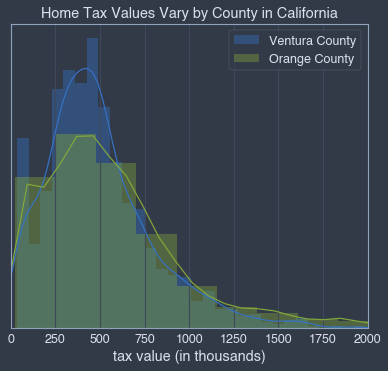

In [149]:
# overlap county tax distributions
sns.distplot(df_6111.taxvalue/1000, label="Ventura County")
sns.distplot(df_6059.taxvalue/1000, label="Orange County")
plt.xlim(0, 2_000)
plt.legend()
plt.yticks([])
plt.title("Home Tax Values Vary by County in California")
plt.xlabel('tax value (in thousands)')
plt.show()


### Split & Scale

In [150]:
# split data into train and test
# a random state of 123 is set to the default in the split function
train, test = split_scale.split_my_data(df, .80)

In [151]:
# break train and test into an X (features) and y (target) dataframe
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test = test[["taxvalue"]]

In [153]:
# scale the X data using the standard scaler
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)

### Explore

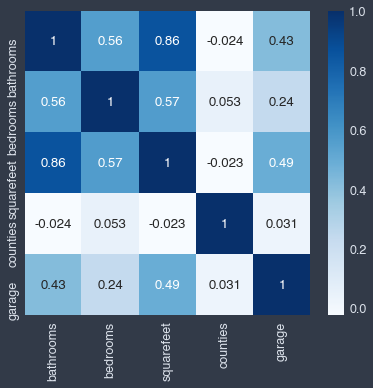

In [154]:
sns.heatmap(X_train_scaled.corr(), cmap='Blues', annot=True)
plt.show()

In [155]:
# H0 = there is no difference between county6059 and county6111
stats.ttest_ind(df_6059.taxvalue, df_6111.taxvalue)

Ttest_indResult(statistic=6.5587398981689375, pvalue=5.947238228780557e-11)

- The p-value is practically zero, therefore, the null hypothesis is rejected

### Feature Selection

In [156]:
# find optimal features
# optimal_features = features.select_kbest_freg(X_train_scaled, y_train, 2)
# optimal_features = features.lasso_cv_coef(X_train_scaled, y_train)
# optimal_features = features.recursive_feature_elimination(X_train,y_train)
optimal_features = features.ols_backware_elimination(X_train_scaled, y_train)
optimal_features

['bathrooms', 'bedrooms', 'squarefeet', 'counties']

In [157]:
# apply optimal features to X_train
X_train = features.features_to_X_train_and_test(X_train_scaled, optimal_features)

### Modeling & Evaluation

In [167]:
# compute the baseline, the mean of y 
baseline = model.compute_baseline(y_train)

In [168]:
# create a new df called predictions, fit and predict based on X_train
predictions = y_train.rename(columns = {"taxvalue":"actuals"})
predictions = model.linear_model(X_train, y_train, predictions)

In [169]:
# calculate the SSE, MSE, RMSE, r2 for the baseline
SSE, MSE, RMSE, r2 = model.evaluate(predictions.actuals, baseline)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.2f}')

SSE  = 338643411280
MSE  = 1423656901020594
RMSE = 581931
r^2  = 0.00


In [170]:
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions.actuals, predictions.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.2f}')

SSE  = 190852378497
MSE  = 802343399203392
RMSE = 436867
r^2  = 0.44


In [171]:
predictions = predictions/1_000_000
baseline = baseline/1_000_000

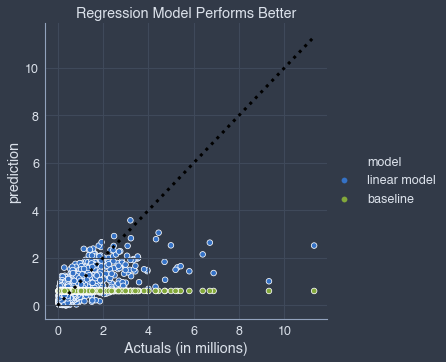

In [174]:
# plot the predicted and baseline values
model.plot_linear_model(predictions.actuals,predictions.lm, baseline)

plt.plot([predictions.min().min(),predictions.max().max()],[predictions.min().min(),predictions.max().max()], \
         c='black', ls=':', linewidth = 3)
plt.title('Regression Model Performs Better')
plt.ticklabel_format(style="plain")
# plt.xticks(rotation=-45)
plt.xlabel("Actuals (in millions)")
plt.show()
